# Gaussian Process Regression Model 

Squared exponential kernel 

$
k(x_1, x_2) = \sigma^2 \exp{(-||x_2 - x_1||^2_2 / (2 \ell^2))}, 
$
where $\ell > 0$ is the correlation length defines how smooth functions and $\sigma^2 > 0$ defines vertical scale, how srongly functions can span vertically.

Multivariate Normal distribution adoptation

$
\mathcal{N}(K_1 K^{-1} y, K_2 - K_1 K^{-1} K_1^\text{T}) + \sigma^2 I 
$

> for TeX typesetting plese use [Markdown All in One](https://marketplace.visualstudio.com/items?itemName=yzhang.markdown-all-in-one) extension. 

In [1]:
# amth
import numpy as np 
from numpy.linalg import inv, det, cholesky
from scipy.optimize import minimize

# plotting 
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns 
import seaborn_image as isns

# interactive 
import ipywidgets as widgets
from ipywidgets import interactive

# use tex fonts
sns.set(font_scale=1.5, rc={'text.usetex' : True})

# this will create thicker lines and larger fonts than usual
isns.set_context("notebook")

# change image related settings
isns.set_image(cmap="deep", despine=True)  # set the colormap and despine the axes
isns.set_scalebar(color="red")             # change scalebar color


/Applications/anaconda3/envs/pyml/lib/python3.7/site-packages/seaborn_image/_context.py:128: UserWarning: Trying to register the cmap 'deep' which already exists.
  register_cmap(name=cmap, cmap=cmap_mpl)


### Code for Square Exponential Kernel (aka RBF) 


In [2]:
class SquareExponentialKernel:

    def __init__(self, sigma=1, ell=1):
        self.sigma = sigma 
        self.ell   = ell 
    
    def __call__(self, x1, x2):
        return self.sigma**2 * np.exp(-np.linalg.norm(x2 - x1)**2 / (2 * self.ell**2))



In [3]:
class MinimizationCallback:
    """Callback for minimize to save intermediate steps."""
    def __init__(self, obj_fun, filename):
        self.best_fun_vals = [np.inf]
        self.best_sols = []
        self.num_calls = 0
        self.obj_fun = obj_fun
        self.filename = filename
    
    def __call__(self, x):
        fun_val = self.obj_fun(x)
        self.num_calls += 1
        #if fun_val < self.best_fun_vals[-1]:
        self.best_sols.append(x)
        self.best_fun_vals.append(fun_val)
        self.save_sols(self.filename)
   
    def save_sols(self, filename):
        sols = np.array([sol for sol in self.best_sols])
        np.savetxt(filename, sols)

### Understanding of the Gaussian process regression



Sample from univariate Gaussian Distribution 

$
P_Y(y) = \dfrac{1}{\sqrt{2 \pi} \sigma} \exp\Big(-\dfrac{(y - \mu)^2}{2 \sigma^2}\Big)
$

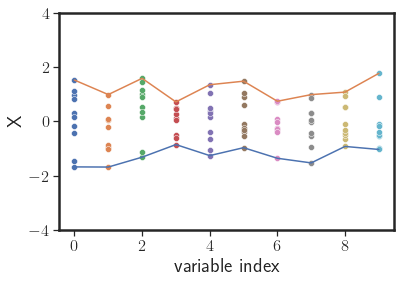

In [4]:
# sample x and y from normal distribution 
nvecs   = 10
samples_num = 10
curves  = []

sns.set_style("white")
sns.set_style("ticks")
for i in range(nvecs):
    # make gaussian vector 
    ys = np.random.normal(size=samples_num)
    xs = [i] * samples_num
    sns.scatterplot(x=xs, y=ys)
    curves.append([np.min(ys), np.max(ys)])

curves = np.array(curves)

for c in range(curves.shape[1]):
    sns.lineplot(x=list(range(nvecs)), y=curves[:, c])

plt.xlabel('variable index')
plt.ylabel('X')
plt.ylim([-4,4])
plt.show()

Sample from the multivariate Gaussian Distribution for $D$-dimensional random vector, components of which are random variables $\vec{Y} = (Y_0, Y_1, ..., Y_D)^\text{T}$ reads 

$
N(\vec{\mu}, \Sigma) = \dfrac{1}{\sqrt{(2 \pi)^D |\Sigma| }} \exp\Big(-\dfrac{1}{2} (\vec{Y} - \vec{\mu})^\text{T}\Sigma^{-1}(\vec{Y} - \vec{\mu})\Big),
$
where $\vec{\mu} = (E[Y_0], E[Y_1], ..., E[Y_D])$, $\Sigma_{i,j} = E[(Y_i - \mu_i)(Y_j - \mu_j)]$ 

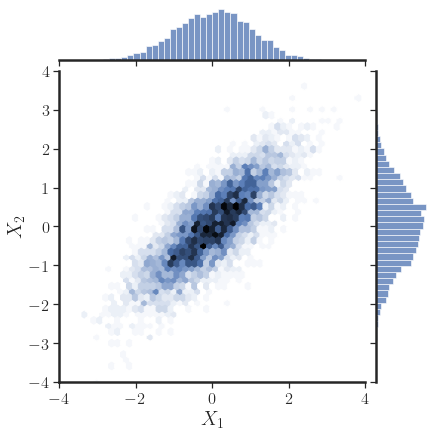

In [5]:
# test mean vector
mean = [0, 0]
# test covariance matrix
cov = [
        [1, 0.8], 
        [0.8, 1]
      ]
# test bivariate sample from multivariate normal distribution
xmg, ymg = np.random.multivariate_normal(mean, cov, 5000).T

sns.jointplot(
    x=xmg, y=ymg,
    kind="hex"
)

plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.show()

In [6]:
def plot_cov_matr(sigma: float, ell: float):
    """ 
    Plot covariance matrix for given parameters.
    Args:
        sigma : (float) defines vertical scale of the funcion, how much vertically function can span
        ell   : (float) defines horizontal scale, indicates how quickly the correlation relationship 
                between two points drops as their distance increases.
                A higher ell provided a smoother function and a smaller ell a wigglier function.
    """
    # make covariance matrix
    rbf = SquareExponentialKernel(sigma=sigma, ell=ell)
    cov_mv = [[rbf(i, j) for i in np.arange(nvecs)] for j in np.arange(nvecs)]
    vars_lbls = [str(i) for i in range(nvecs)]
    # plot covariance matrix
    fig, ax = plt.subplots(figsize=(6,6)) 
    sns.heatmap(
        cov_mv,
        xticklabels=vars_lbls,
        yticklabels=vars_lbls,
        cmap="YlGnBu",
        annot=True, 
        ax=ax,
        fmt='.1f',
        cbar_kws={'label': 'Correlation'}
        )
    plt.title('Covariance matrix')
    plt.show()

In [7]:
interactive_plot_covmatr = interactive(plot_cov_matr, 
                                       sigma=(0.001, 2.1, 0.1), 
                                       ell=(0.001, 4.0, 0.25),
                                       )
output_covmatr = interactive_plot_covmatr.children[-1]
output_covmatr.layout.height = '400px'
interactive_plot_covmatr

interactive(children=(FloatSlider(value=1.001, description='sigma', max=2.1, min=0.001), FloatSlider(value=1.7…

In [8]:
def plot_prior_curves(sigma: float, ell: float):
    """ 
    Plot curves based on sampled points from multivariate Gaussian distribution.
    Args:
        sigma : (float) defines vertical scale of the funcion, how much vertically function can span
        ell   : (float) defines horizontal scale, indicates how quickly the correlation relationship 
                between two points drops as their distance increases.
                A higher ell provided a smoother function and a smaller ell a wigglier function.
    """
    # make covariance matrix from the RBF kernel 
    rbf = SquareExponentialKernel(sigma=sigma, ell=ell)
    cov_mv = [[rbf(i, j) for i in np.arange(nvecs)] for j in np.arange(nvecs)]
    vars_lbls = [str(i) for i in range(nvecs)]

    mean_mv = nvecs * [0]
    # draw samples from the multivariate gaussian distribution
    ymv = np.random.multivariate_normal(mean_mv, cov_mv, samples_num).T 

    sns.set_style("white")
    sns.set_style("ticks")

    for i in range(3):
        sns.scatterplot(x=range(nvecs), y=ymv[:, i])
        sns.lineplot(x=range(nvecs), y=ymv[:, i])

    plt.xlabel('variable index')
    plt.ylabel('y')
    plt.ylim([-4,4])
    plt.show()

In [9]:
interactive_plot_prior = interactive(plot_prior_curves, 
                                     sigma=(0.001, 2.1, 0.1), 
                                     ell=(0.001, 4.0, 0.25),
                                    )
output_prior = interactive_plot_prior.children[-1]
output_prior.layout.height = '400px'
interactive_plot_prior

interactive(children=(FloatSlider(value=1.001, description='sigma', max=2.1, min=0.001), FloatSlider(value=1.7…

### Conditioning of the Multivariate Gaussian Distribution 

Let us consider the joined distribution of $n$ training outputs $\boldsymbol{X}$ and $m$ test outputs $\boldsymbol{Y}$.


\begin{align}

\begin{bmatrix}
\boldsymbol{X} \\ 
\boldsymbol{Y}
\end{bmatrix} \sim
\mathcal{N}
\Bigg(
0,
\begin{bmatrix}
K(X, X) & K(X, Y) \\ 
K(Y, X) & K(Y, Y) 
\end{bmatrix}
\Bigg)
\end{align}

where $K(X, Y)$ denotes $n \times m$ matrix of the covariances evaluated at all pairs of training and test points, and similarly for the other entries $K(X, X)$, $K(Y, Y)$ and $K(Y, X)$.

 


In [10]:
def get_cond_mean_cov(points_train, points_test, sigma, ell) -> tuple:
    """ 
    Get mean and covariance matrix for conditioned mulitvariate Gaussian distribution.
    Args:
        points_train : (np.array) training points [(x_i, f_i), ...]
        points_test  : (np.array) test points [(x_i, f_i), ...]
        sigma        : (float) defines vertical scale of the funcion, how much vertically function can span
        ell          : (float) defines horizontal scale, indicates how quickly the correlation relationship 
                        between two points drops as their distance increases.
        old_mean     : (np.array) vector of mean for mulitvariate Gaussian distribution
        old_cov      : (np.array) covariance matrix for mulitvariate Gaussian distribution
    Returns:
        (new_mean, new_cov)
    """
    rbf = SquareExponentialKernel(sigma=sigma, ell=ell)

    # abscissas of training and test points
    x_train = points_train[:, 0]
    x_test  = points_test[:, 0]
    
    # ordinates of training points
    y_train = points_train[:, 1].T

    Kxx = np.array([[rbf(_, __) for _ in x_train] for __ in x_train])
    Kxy = np.array([[rbf(_, __) for _ in x_train] for __ in x_test])
    Kyx = np.array([[rbf(_, __) for _ in x_test] for __ in x_train])
    Kyy = np.array([[rbf(_, __) for _ in x_test] for __ in x_test])

    # mean of training and test
    m_train = np.array([0] * x_train.shape[0]).T
    m_test  = np.array([0] * x_test.shape[0]).T
    
    new_mean = Kxy.dot(inv(Kxx)).dot(y_train) 
    new_cov  = Kyy - Kxy.dot(inv(Kxx)).dot(Kyx) 

    return (new_mean, new_cov)

In [11]:
def plot_posterior_curves(sigma: float, ell: float):
    """ 
    Plot curves based on sampled points from multivariate Gaussian distribution.
    Args:
        sigma : (float) defines vertical scale of the funcion, how much vertically function can span
        ell   : (float) defines horizontal scale, indicates how quickly the correlation relationship 
                between two points drops as their distance increases.
                A higher ell provided a smoother function and a smaller ell a wigglier function.
        points: (np.array) ordinate of fixed training points
    """
    # test train points
    points_train = np.array([[0, 0.2], [1, 0.3], [6, 0.5]])
    points_test  = np.array([[2], [3], [4], [5], [7], [8], [9]])

    # compute mean and covariance matrix of the conditioned distribution
    new_mean, new_cov = get_cond_mean_cov(points_train, points_test, sigma, ell)

    # draw samples from the conditioned multivariate gaussian distribution
    ymv = np.random.multivariate_normal(new_mean, new_cov, samples_num).T 
    
    sns.set_style("white")
    sns.set_style("ticks")

    for i in range(5):
        # test points 
        sns.scatterplot(x=points_test[:, 0], y=ymv[:, i])
        # [(x, y), ...] predicted curve 
        temp_pred_xy = np.column_stack((points_test[:, 0], ymv[:, i]))
        temp_curve = np.concatenate((points_train, temp_pred_xy), axis=0)

        sns.lineplot(x=temp_curve[:, 0], y=temp_curve[:, 1])

    # plot train points 
    sns.scatterplot(x=points_train[:, 0], y=points_train[:, 1], color='red', s=200, marker='X')

    plt.xlabel('variable index')
    plt.ylabel('y')
    plt.ylim([-4,4])
    plt.show()

In [12]:
interactive_plot_posterior = interactive(plot_posterior_curves, 
                                       sigma=(0.001, 2.1, 0.1), 
                                       ell=(0.001, 4.0, 0.25),
                                       )
output_posterior = interactive_plot_posterior.children[-1]
output_posterior.layout.height = '400px'
interactive_plot_posterior

interactive(children=(FloatSlider(value=1.001, description='sigma', max=2.1, min=0.001), FloatSlider(value=1.7…

In [13]:
 # test train points
#points_train = np.array([[0, 1], [1, 2], [2, 0], [3, -2.5]])
#points_test  = np.array([[i] for i in np.arange(0, 4, 0.05) if i not in points_train[:, 0]])

#
points_train = np.array([[-3, 1.25], [-2, -0.5], [-1.45, 0.33], [-1.5, 0.35], [-1, 0.45], [-0.8, 0.5], [-0.6, -0.5], [-0.1, -0.52], [0.3, 1], [0.65, 1.2], [1.1, -1.5], [1.5, -1.55], [2, -0.5], [2.5, -0.1], [3, 0.5]])
points_test  = np.array([[i] for i in np.arange(-4, 4, 0.05) if i not in points_train[:, 0]])



In [14]:
def plot_posterior_curves_continum(sigma: float, ell: float):
    """ 
    Plot curves based on sampled points from multivariate Gaussian distribution.
    Args:
        sigma : (float) defines vertical scale of the funcion, how much vertically function can span
        ell   : (float) defines horizontal scale, indicates how quickly the correlation relationship 
                between two points drops as their distance increases.
                A higher ell provided a smoother function and a smaller ell a wigglier function.
        points: (np.array) ordinate of fixed training points
    """
    curves_num = 100
    
    # compute log marginal likelihood 
    logmarglkh = make_log_marg_likelihood(points_train[:, 0], points_train[:, 1])

    # compute mean and covariance matrix of the conditioned distribution
    new_mean, new_cov = get_cond_mean_cov(points_train, points_test, sigma, ell)

    # draw samples from the conditioned multivariate gaussian distribution
    ymv   = np.random.multivariate_normal(new_mean, new_cov, curves_num).T 
    ymean = np.mean(ymv, axis=1)
    std   = np.std(ymv, axis=1)
    
    mean_pred_xy = np.column_stack((points_test[:, 0], ymean))
    mean_curve   = np.concatenate((points_train, mean_pred_xy), axis=0)

    std_upper_xy = np.column_stack((points_test[:, 0], ymean + std))
    std_lower_xy = np.column_stack((points_test[:, 0], ymean - std))

    std_upper_curve = np.concatenate((points_train, std_upper_xy), axis=0)
    std_lower_curve = np.concatenate((points_train, std_lower_xy), axis=0)

    sns.set_style("white")
    sns.set_style("ticks")
    # plot mean curve
    sns.lineplot(x=mean_curve[:, 0], y=mean_curve[:, 1], color='red')
    # plot upper uncertainty curve
    sns.lineplot(x=std_upper_curve[:, 0], y=std_upper_curve[:, 1], color='blue') 
    # plot lower uncertainty curve
    sns.lineplot(x=std_lower_curve[:, 0], y=std_lower_curve[:, 1], color='blue') 
    plt.fill_between(std_upper_xy[:, 0], std_upper_xy[:, 1], std_lower_xy[:, 1], alpha=0.2)  

    # plot train points 
    sns.scatterplot(x=points_train[:, 0], y=points_train[:, 1], color='red', s=100, marker='o')
    
    plt.title(f'log marg. likelihood: {logmarglkh([ell, sigma]):.4f}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.ylim([-3, 3])
    # plt.savefig('imgs/medium_l.svg')
    plt.show()

### Hyperparameters optimization 

The set of optimal parameters are calculated via optimization of log marginal likelyhood 

$
\log p(\vec{y}| X) = -\dfrac{1}{2} \vec{y}_\text{trained}^T \mathcal{K}^{-1} \vec{y}_\text{trained} - \dfrac{1}{2} \log |\mathcal{K}| - \dfrac{n}{2} \log 2 \pi,
$
where $\mathcal{K} = K + \sigma_n^2 I$ is covariance matrix calculated on the trained points with kernel $K = k(\vec{x}_\text{trained}, \vec{x}_\text{trained})$, $\sigma_n$ is noise level.


[Edward Rasmussen, Gaussian Processes for Machine Learning, ISBN 0-262-18253-X, (2006)](http://gaussianprocess.org/gpml/chapters/RW.pdf)

In [15]:
def make_log_marg_likelihood(X_train: np.ndarray, Y_train: np.ndarray, noise=0.2) -> ():
    """
    Returns function which computes log marginal likelihood for given training points.
    Args:
        X_train : (np.array) 
        Y_train : (np.array)
    """
    Y_train = Y_train.ravel()
    
    def log_marg_likelihood(theta: list):
        """Function to compute Log marginal likelihood.
        Args:
            theta: (list) [ell, sigma] hyperparameters of the Square Exponential kernel. 
        """
        kernel = SquareExponentialKernel(ell=theta[0], sigma=theta[1])
        K = np.array([[kernel(x_1, x_2) for x_1 in X_train] for x_2 in X_train]) + \
            noise**2 * np.eye(len(X_train))
        
        # print(f'log det K: {np.log(det(K))}')

        return  0.5 * Y_train.dot(inv(K).dot(Y_train)) + \
                0.5 * np.log(det(K)) + \
                0.5 * len(X_train) * np.log(2*np.pi)
    
    return log_marg_likelihood
    

In [16]:
interactive_plot_posterior_continum = interactive(plot_posterior_curves_continum, 
                                       sigma=(0.001, 1.1, 0.1), 
                                       ell=(0.001, 1.0, 0.1),
                                       )
output_posterior_continum = interactive_plot_posterior_continum.children[-1]
output_posterior_continum.layout.height = '400px'
interactive_plot_posterior_continum

interactive(children=(FloatSlider(value=0.501, description='sigma', max=1.1, min=0.001), FloatSlider(value=0.4…

In [469]:
init_ell, init_sigma = 0.01, 2.0

lml = make_log_marg_likelihood(points_train[:, 0], points_train[:, 1])

cb = MinimizationCallback(lml, 'opt/history.dat') 

res = minimize(lml, [init_ell, init_sigma], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B', callback=cb)
print(res)

      fun: 16.26550779455502
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.66977543e-05, -1.56319401e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 111
      nit: 14
     njev: 37
   status: 0
  success: True
        x: array([0.34354015, 0.87610244])


In [464]:
# optimal points calculated with gradient descend
optimal_ell, optimal_sigma  = res.x


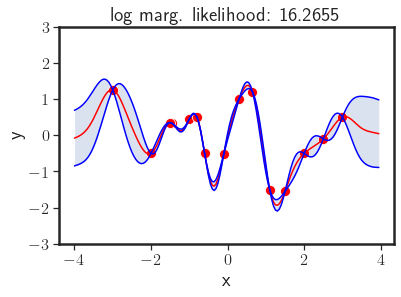

In [465]:
plot_posterior_curves_continum(ell=optimal_ell, sigma=optimal_sigma)

In [455]:
alphas = np.arange(0, 2, 1e-2) 
sigmas = np.arange(0, 2, 1e-2) 


In [456]:
grid =  np.array([[[alpha, sigma] for sigma in sigmas] for alpha in alphas])

lml_on_grid = np.vectorize(lml, signature='(n)->()')(grid)


/Applications/anaconda3/envs/pyml/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/Applications/anaconda3/envs/pyml/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  
/Applications/anaconda3/envs/pyml/lib/python3.7/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


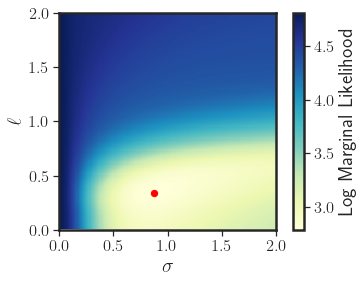

In [459]:
plt.imshow(np.log(lml_on_grid), extent=(0, 2, 0, 2), cmap='YlGnBu')
plt.colorbar(label='Log Marginal Likelihood', orientation='vertical')

plt.scatter([optimal_sigma], [optimal_ell], s=40, color='red')

plt.xlabel(r'$\sigma$')
plt.ylabel(r'$\ell$')

#plt.savefig('imgs/log_marg_lkh.png', dpi=350, transparent=True)
plt.show()

### Make Video

In [466]:
def make_log_marg_likelihood_and_squared(X_train: np.ndarray, Y_train: np.ndarray, noise=0.01) -> ():
    """
    Returns function which computes log marginal likelihood for given training points.
    Args:
        X_train : (np.array) 
        Y_train : (np.array)
    """
    Y_train = Y_train.ravel()
    
    def log_marg_likelihood_and_squared(theta: list):
        """
        Function to compute Log marginal likelihood.
        Args:
            theta: (list) [ell, sigma] hyperparameters of the Square Exponential kernel. 
        Returns:
            (tuple): (LML, squared_term)
        """
        kernel = SquareExponentialKernel(ell=theta[0], sigma=theta[1])
        K = np.array([[kernel(x_1, x_2) for x_1 in X_train] for x_2 in X_train]) + \
            noise**2 * np.eye(len(X_train))
        # terms of the log marginal likelihood
        squared     = 0.5 * Y_train.dot(inv(K).dot(Y_train))
        determinant = 0.5 * np.log(det(K))
        const       = 0.5 * len(X_train) * np.log(2*np.pi)
        lml         = squared + determinant + const
        return (lml, squared)
    
    return log_marg_likelihood_and_squared

def plot_posterior_curves_continum_pasive(sigma: float, ell: float, lml_on_grid: np.array, fname: str = None):
    """ 
    Plot curves based on sampled points from multivariate Gaussian distribution.
    Args:
        sigma : (float) defines vertical scale of the funcion, how much vertically function can span
        ell   : (float) defines horizontal scale, indicates how quickly the correlation relationship 
                between two points drops as their distance increases.
                A higher ell provided a smoother function and a smaller ell a wigglier function.
        points: (np.array) ordinate of fixed training points
    """
    curves_num = 100
    
    # compute log marginal likelihood 
    optim_func = make_log_marg_likelihood_and_squared(points_train[:, 0], points_train[:, 1])
    lml, datafit = optim_func([ell, sigma])

    # compute mean and covariance matrix of the conditioned distribution
    new_mean, new_cov = get_cond_mean_cov(points_train, points_test, sigma, ell)

    # draw samples from the conditioned multivariate gaussian distribution
    ymv   = np.random.multivariate_normal(new_mean, new_cov, curves_num).T 
    ymean = np.mean(ymv, axis=1)
    std   = np.std(ymv, axis=1)
    
    mean_pred_xy = np.column_stack((points_test[:, 0], ymean))
    mean_curve   = np.concatenate((points_train, mean_pred_xy), axis=0)

    std_upper_xy = np.column_stack((points_test[:, 0], ymean + std))
    std_lower_xy = np.column_stack((points_test[:, 0], ymean - std))

    std_upper_curve = np.concatenate((points_train, std_upper_xy), axis=0)
    std_lower_curve = np.concatenate((points_train, std_lower_xy), axis=0)


    # plotting 
    fig = plt.figure(figsize=(7,3), constrained_layout=True)
    gs = fig.add_gridspec(nrows=1, ncols=3, left=0., right=0.1, wspace=0.0)

    f_ax2 = fig.add_subplot(gs[-1, :-1])

    #sns.set_style("white")
    #sns.set_style("ticks")

    # plot mean curve
    sns.lineplot(x=mean_curve[:, 0], y=mean_curve[:, 1], color='red')
    # plot upper uncertainty curve
    sns.lineplot(x=std_upper_curve[:, 0], y=std_upper_curve[:, 1], color='blue') 
    # plot lower uncertainty curve
    sns.lineplot(x=std_lower_curve[:, 0], y=std_lower_curve[:, 1], color='blue') 
    plt.fill_between(std_upper_xy[:, 0], std_upper_xy[:, 1], std_lower_xy[:, 1], alpha=0.2)  

    # plot train points 
    sns.scatterplot(x=points_train[:, 0], y=points_train[:, 1], color='red', s=60, marker='o')
    
    plt.title(f'datafit: {datafit:.4f}, LML: {lml:.4f}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.ylim([-4, 4])

    f_ax3 = fig.add_subplot(gs[-1, -1])
    im = f_ax3.imshow(np.log(lml_on_grid), extent=(0, 2, 0, 2), cmap='YlGnBu')
    divider = make_axes_locatable(f_ax3)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax, label='Log Marginal Likelihood', orientation='vertical')
    f_ax3.scatter([sigma], [ell], s=40, color='red')
    f_ax3.set_xlabel(r'$\sigma$')
    f_ax3.set_ylabel(r'$\ell$')
    plt.savefig(fname)
    
    plt.clf()
    #plt.show()

/Applications/anaconda3/envs/pyml/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: covariance is not positive-semidefinite.


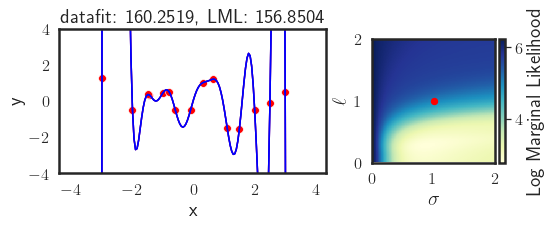

In [408]:
plot_posterior_curves_continum_pasive(sigma=1, ell=1, lml_on_grid=lml_on_grid, fname='1')

#### To Create Movie Run

```
ffmpeg -r 1 -i snap_%01d.jpg -vcodec mpeg4 -y movie.mp4
```

In [471]:
# read ninimization history 
history = np.loadtxt('opt/history.dat')

i = 0
for ell, sigma in history:
    fname = f'opt/snaps/snap_{i}.jpg'
    plot_posterior_curves_continum_pasive(sigma=sigma, ell=ell, lml_on_grid=lml_on_grid, fname=fname)
    i += 1
    
# print(history)

<Figure size 504x216 with 0 Axes>

<Figure size 504x216 with 0 Axes>

<Figure size 504x216 with 0 Axes>

<Figure size 504x216 with 0 Axes>

<Figure size 504x216 with 0 Axes>

<Figure size 504x216 with 0 Axes>

<Figure size 504x216 with 0 Axes>

<Figure size 504x216 with 0 Axes>

<Figure size 504x216 with 0 Axes>

<Figure size 504x216 with 0 Axes>

<Figure size 504x216 with 0 Axes>

<Figure size 504x216 with 0 Axes>

<Figure size 504x216 with 0 Axes>

<Figure size 504x216 with 0 Axes>